In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import scipy.stats as stats
from scipy.stats import gamma, kstest
from scipy.stats import boxcox, boxcox_normmax

from sklearn.preprocessing import LabelEncoder,MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import kerastuner as kt
import joblib


import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/vm/ry33clp516s3sqkhn8jf5bg00000gn/T/ipykernel_18410/10071671.py:19: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', 1000)

# Data Processing

## 1. Data Merging and converting to datetime

In [3]:
df_venues = pd.read_csv("venues.csv")
df_bills = pd.read_csv("bills.csv")
df_holidays = pd.read_csv("holiday.csv")

In [4]:
df_venues["concept"].fillna("NA", inplace=True)

In [5]:
df = pd.merge(df_bills, df_venues, on='venue_xref_id', how='left')

In [6]:
df['business_date'] = pd.to_datetime(df['business_date'])
df_holidays['Date'] = pd.to_datetime(df_holidays['Date'])
df['year_week'] = df['business_date'].dt.strftime('%Y-%U')

In [7]:
df_holidays["Country"] = df_holidays["Country"].replace({"Canada": "CA", "USA": "US"})

In [8]:
df = pd.merge(df, df_holidays, how="left", 
                     left_on=["business_date", "country"],
                     right_on=["Date", "Country"])

# creating 'is_holiday' cloumn: if holiday = 1, else = 0.
df["is_holiday"] = df["Date"].notna().astype(int)

df.drop(columns=["Date", "Holiday", "Day", "Country"], inplace=True)

## 2. Removing outliers

In [9]:
df["sales_revenue_with_tax"].describe()

count    8.954786e+06
mean     3.674902e+01
std      8.337668e+01
min     -5.731500e+03
25%      1.044000e+01
50%      2.189000e+01
75%      4.465000e+01
max      7.492861e+04
Name: sales_revenue_with_tax, dtype: float64

In [10]:
df["payment_count"].describe()

count    8.954786e+06
mean     9.844425e-01
std      1.926432e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      4.100000e+01
Name: payment_count, dtype: float64

In [11]:
df["payment_total_tip"].describe()

count    8.954786e+06
mean     3.654212e+00
std      1.753186e+02
min     -2.531400e+02
25%      0.000000e+00
50%      0.000000e+00
75%      4.070000e+00
max      5.227156e+05
Name: payment_total_tip, dtype: float64

In [12]:
df["order_duration_seconds"].describe()

count    8.954786e+06
mean     8.790968e+03
std      3.984398e+05
min     -4.400000e+01
25%      1.100000e+02
50%      1.159000e+03
75%      3.377000e+03
max      2.894124e+08
Name: order_duration_seconds, dtype: float64

In [13]:
df = df[(df["order_duration_seconds"] >= 0) & (df["order_duration_seconds"] <= 20000)]

In [14]:
df = df[(df["payment_count"] > 0)]

In [15]:
df = df[df["sales_revenue_with_tax"] >= 0]

### Grouping data by week

In [17]:
group_cols = ['venue_xref_id', 'year_week']

data = df.groupby(group_cols).agg({
    'sales_revenue_with_tax': 'sum',    
    'payment_total_tip': 'sum',         
    'payment_count': 'sum',            
    'order_duration_seconds': 'mean',   
    'concept': 'first',                
    'city': 'first',                   
    'country': 'first',                 
    'is_holiday': 'max'
    
}).reset_index()


In [18]:
data['payment_total_tip'].describe()

count     15171.000000
mean       2137.431160
std        5263.093734
min         -20.580000
25%         171.625000
50%        1001.860000
75%        2648.825000
max      522783.480000
Name: payment_total_tip, dtype: float64

In [20]:
data = data[(data["payment_total_tip"] <= 40000)]

## Transforming features

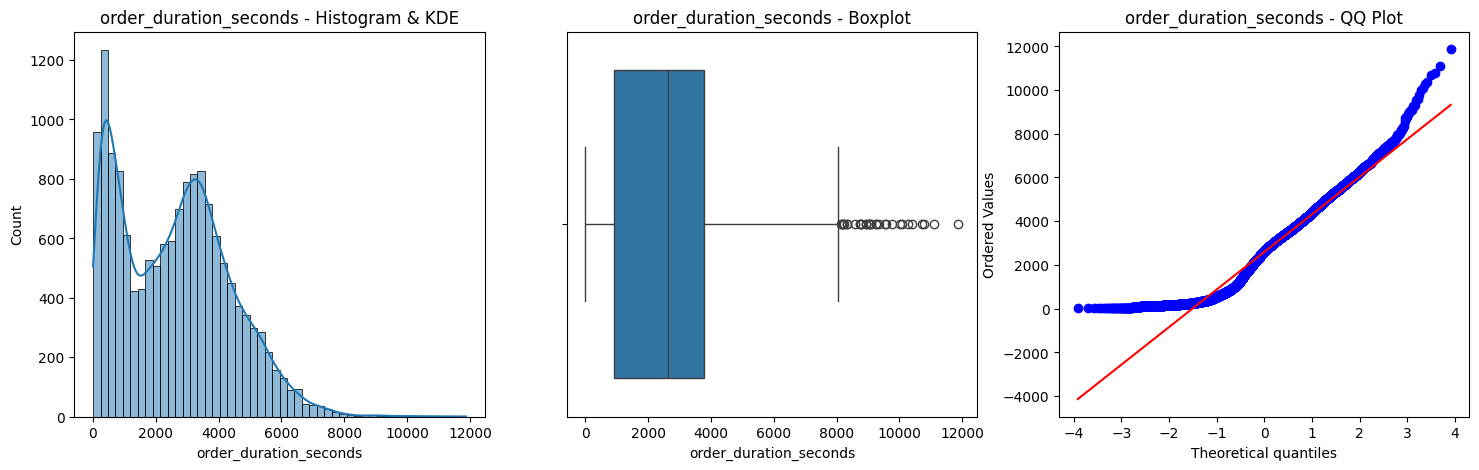

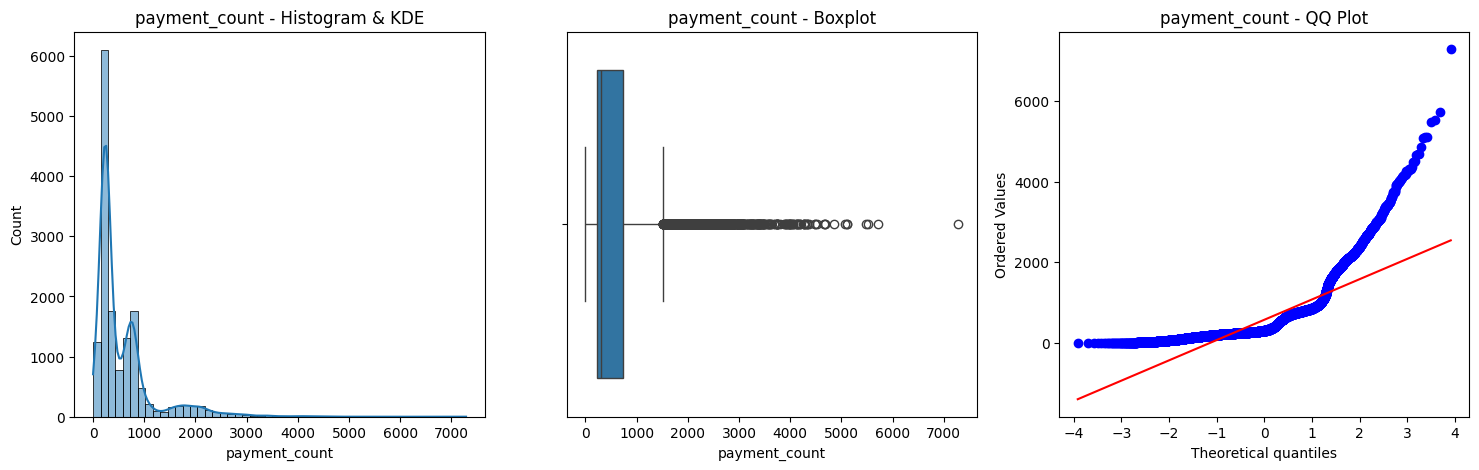

In [21]:
features = ["order_duration_seconds", "payment_count"]

for feature in features:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Histogram
    sns.histplot(data[feature], bins=50, kde=True, ax=axes[0])
    axes[0].set_title(f"{feature} - Histogram & KDE")
    
    # Boxplot
    sns.boxplot(x=data[feature], ax=axes[1])
    axes[1].set_title(f"{feature} - Boxplot")
    
    # QQplot
    stats.probplot(data[feature], dist="norm", plot=axes[2])
    axes[2].set_title(f"{feature} - QQ Plot")

    plt.show()


In [22]:
data["order_duration_seconds_box"], lambda_order = boxcox(data["order_duration_seconds"] + 1)
data["payment_count_box"], lambda_count = boxcox(data["payment_count"] + 1)

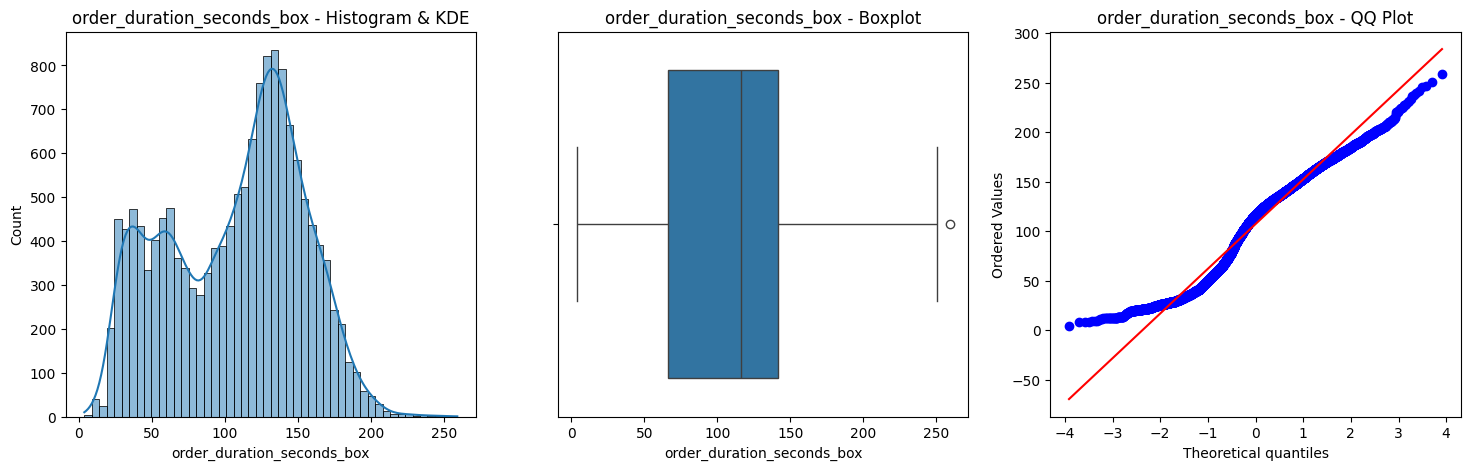

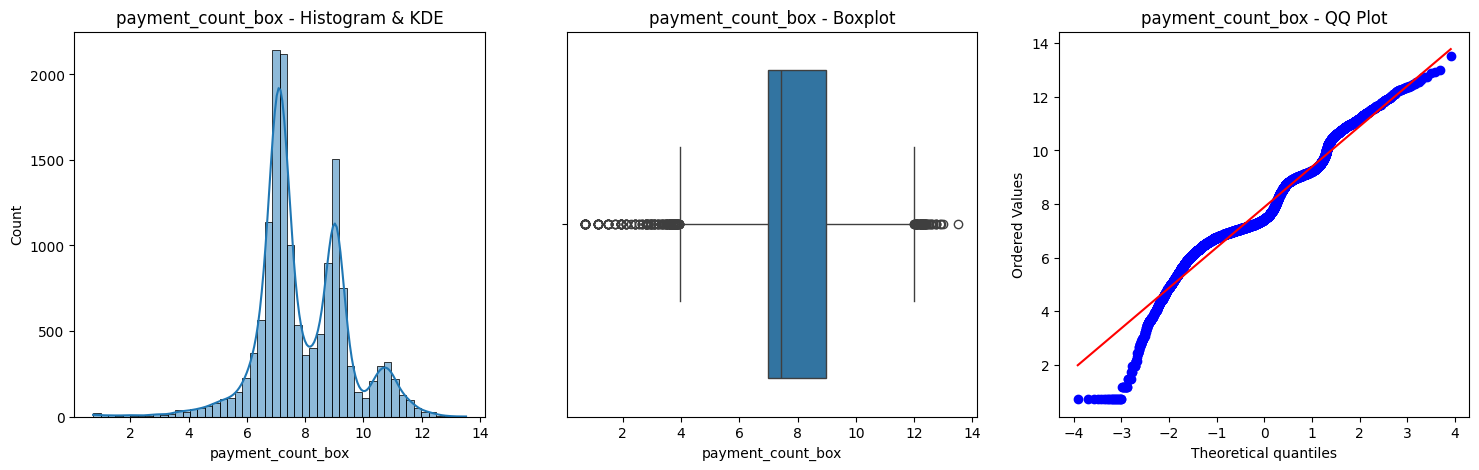

In [23]:
features = ["order_duration_seconds_box", "payment_count_box"]

for feature in features:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Histogram
    sns.histplot(data[feature], bins=50, kde=True, ax=axes[0])
    axes[0].set_title(f"{feature} - Histogram & KDE")
    
    # Boxplot
    sns.boxplot(x=data[feature], ax=axes[1])
    axes[1].set_title(f"{feature} - Boxplot")
    
    # QQplot
    stats.probplot(data[feature], dist="norm", plot=axes[2])
    axes[2].set_title(f"{feature} - QQ Plot")

    plt.show()


In [24]:
data["sales_revenue_with_tax"].describe()

count     15169.000000
mean      21256.686957
std       22416.881120
min           0.000000
25%        7201.950000
50%       13251.510000
75%       27400.460000
max      212420.930000
Name: sales_revenue_with_tax, dtype: float64

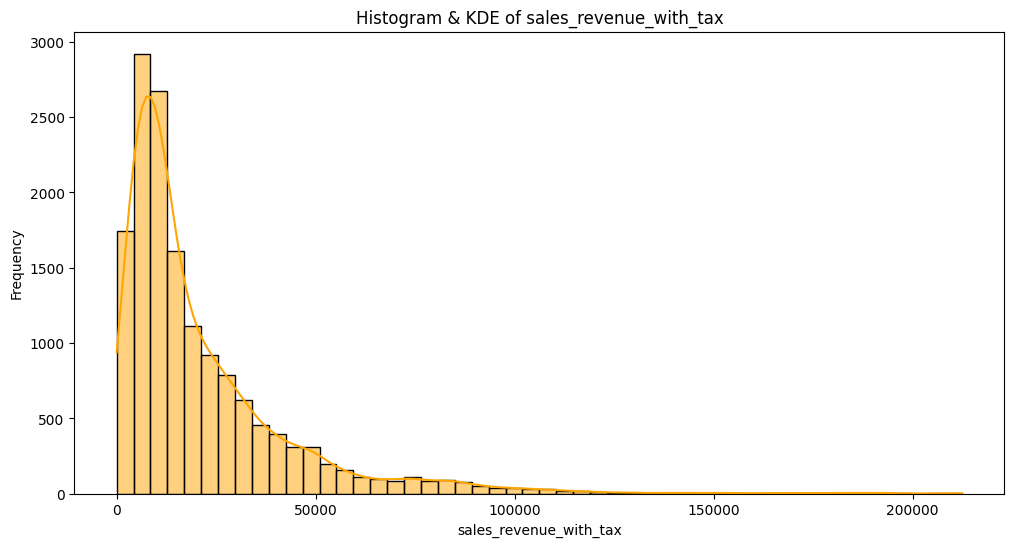

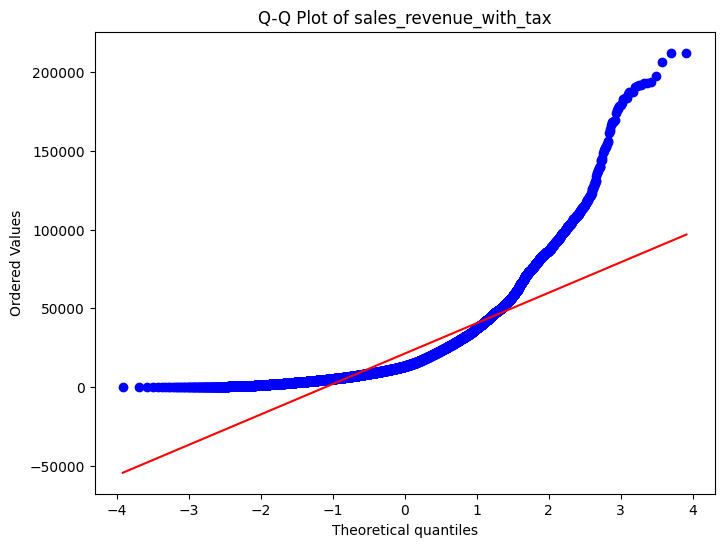

In [25]:
plt.figure(figsize=(12, 6))
sns.histplot(data["sales_revenue_with_tax"], bins=50, kde=True, color="orange")
plt.title("Histogram & KDE of sales_revenue_with_tax")
plt.xlabel("sales_revenue_with_tax")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 6))
stats.probplot(data["sales_revenue_with_tax"], dist="norm", plot=plt)
plt.title("Q-Q Plot of sales_revenue_with_tax")
plt.show()

IQR Outlier Range: -23095.815 ~ 57698.225
Number of outliers: 1016


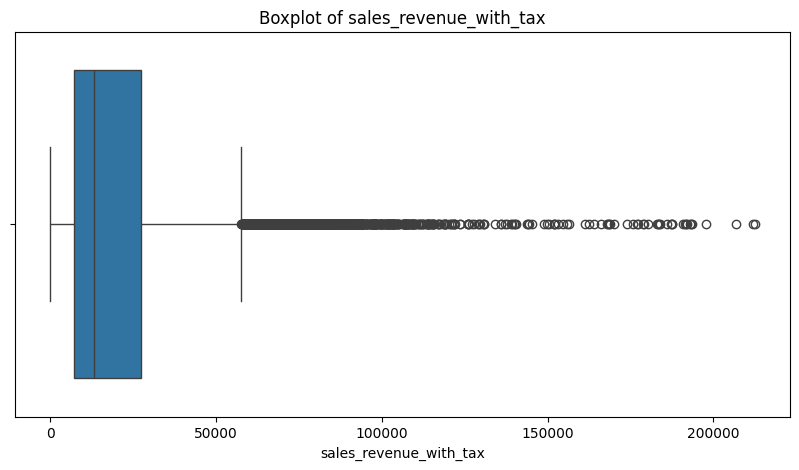

In [26]:
Q1 = data["sales_revenue_with_tax"].quantile(0.25)
Q3 = data["sales_revenue_with_tax"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"IQR Outlier Range: {lower_bound} ~ {upper_bound}")

outliers = data[(data["sales_revenue_with_tax"] < lower_bound) | (data["sales_revenue_with_tax"] > upper_bound)]
print(f"Number of outliers: {len(outliers)}")

plt.figure(figsize=(10,5))
sns.boxplot(x=data["sales_revenue_with_tax"])
plt.title("Boxplot of sales_revenue_with_tax")
plt.show()

In [27]:
upper_bound = 57698.225
data["sales_revenue_with_tax_clip"] = np.clip(data["sales_revenue_with_tax"], 0, upper_bound)

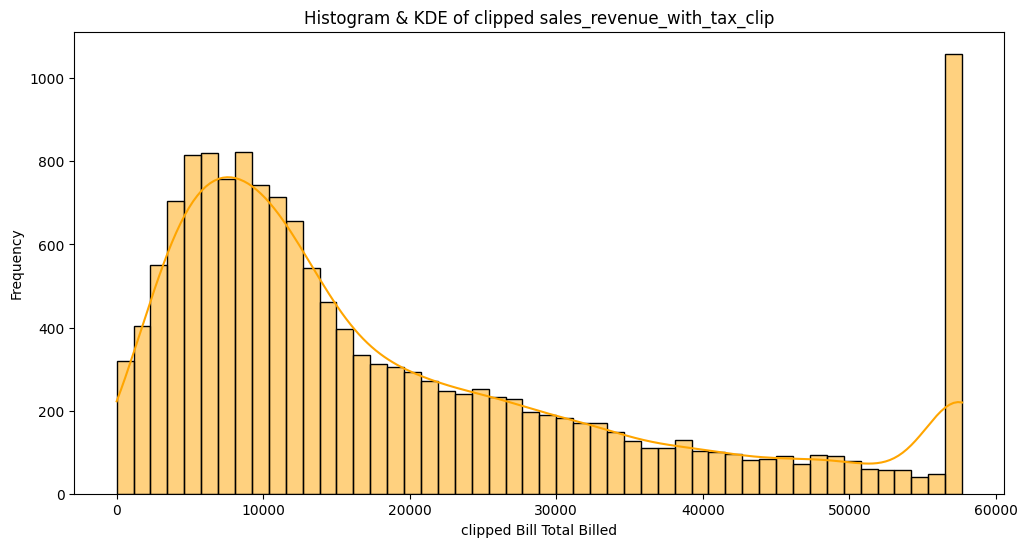

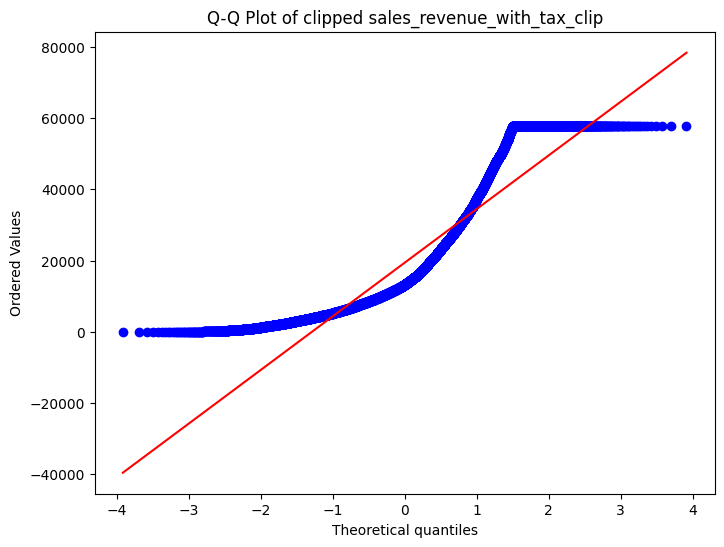

In [28]:
plt.figure(figsize=(12, 6))
sns.histplot(data["sales_revenue_with_tax_clip"], bins=50, kde=True, color="orange")
plt.title("Histogram & KDE of clipped sales_revenue_with_tax_clip")
plt.xlabel("clipped Bill Total Billed")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 6))
stats.probplot(data["sales_revenue_with_tax_clip"], dist="norm", plot=plt)
plt.title("Q-Q Plot of clipped sales_revenue_with_tax_clip")
plt.show()

## Adding features

In [29]:
data["prev_week_sales"] = data.groupby("venue_xref_id")["sales_revenue_with_tax_clip"].shift(1)
data["prev_2week_sales"] = data.groupby("venue_xref_id")["sales_revenue_with_tax_clip"].shift(2)
data["prev_3week_sales"] = data.groupby("venue_xref_id")["sales_revenue_with_tax_clip"].shift(3)
data["moving_avg_4weeks"] = data.groupby("venue_xref_id")["sales_revenue_with_tax_clip"].rolling(window=4, min_periods=1).mean().reset_index(level=0, drop=True)

data["prev_week_sales"] = data["prev_week_sales"].fillna(0)
data["prev_2week_sales"] = data["prev_2week_sales"].fillna(0)
data["prev_3week_sales"] = data["prev_3week_sales"].fillna(0)
data["moving_avg_4weeks"] = data["moving_avg_4weeks"].fillna(0)

In [30]:
data = data.sort_values(['venue_xref_id', 'year_week'])

In [31]:
data.to_csv("data.csv", index=False)

# Model Preparation

In [32]:
df_model = data.copy()

cat_cols = ["concept", "city", "country"]

for col in cat_cols:
    le = LabelEncoder()
    df_model[col] = df_model[col].fillna("NA")  # NaN 방어
    df_model[col] = le.fit_transform(df_model[col].astype(str))

le_venue = LabelEncoder()
df_model["venue_xref_id"] = le_venue.fit_transform(df_model["venue_xref_id"].astype(str))

## Feature Scaling

In [33]:
cols_to_scale = ["payment_total_tip", "payment_count_box", "order_duration_seconds_box"]

robust_scaler = RobustScaler()
df_model[cols_to_scale] = robust_scaler.fit_transform(df_model[cols_to_scale])

minmax_scaler = MinMaxScaler()
df_model[cols_to_scale] = minmax_scaler.fit_transform(df_model[cols_to_scale])

print(df_model[cols_to_scale].describe())

       payment_total_tip  payment_count_box  order_duration_seconds_box
count       15169.000000       15169.000000                15169.000000
mean            0.062377           0.559481                    0.404785
std             0.091547           0.120459                    0.180061
min             0.000000           0.000000                    0.000000
25%             0.005653           0.488379                    0.244606
50%             0.030066           0.523870                    0.441143
75%             0.078427           0.645547                    0.539735
max             1.000000           1.000000                    1.000000


In [34]:
df_model["sales_revenue_with_tax_clip"].round(2)

0         7025.35
1         9539.39
2        10226.74
3         9014.09
4         9199.71
           ...   
15166    23950.16
15167    32346.86
15168    21775.59
15169    12590.87
15170     8093.11
Name: sales_revenue_with_tax_clip, Length: 15169, dtype: float64

In [36]:
scaler = MinMaxScaler()
df_model["sales_revenue_with_tax_clip"] = scaler.fit_transform(df_model[["sales_revenue_with_tax_clip"]])
df_model["sales_revenue_with_tax_clip"].describe()

count    15169.000000
mean         0.336239
std          0.282405
min          0.000000
25%          0.124821
50%          0.229669
75%          0.474893
max          1.000000
Name: sales_revenue_with_tax_clip, dtype: float64

In [37]:
joblib.dump(scaler, "target_scaler.pkl")

['target_scaler.pkl']

In [38]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15169 entries, 0 to 15170
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   venue_xref_id                15169 non-null  int64  
 1   year_week                    15169 non-null  object 
 2   sales_revenue_with_tax       15169 non-null  float64
 3   payment_total_tip            15169 non-null  float64
 4   payment_count                15169 non-null  int64  
 5   order_duration_seconds       15169 non-null  float64
 6   concept                      15169 non-null  int64  
 7   city                         15169 non-null  int64  
 8   country                      15169 non-null  int64  
 9   is_holiday                   15169 non-null  int64  
 10  order_duration_seconds_box   15169 non-null  float64
 11  payment_count_box            15169 non-null  float64
 12  sales_revenue_with_tax_clip  15169 non-null  float64
 13  prev_week_sales      

### Correlation matrix of features

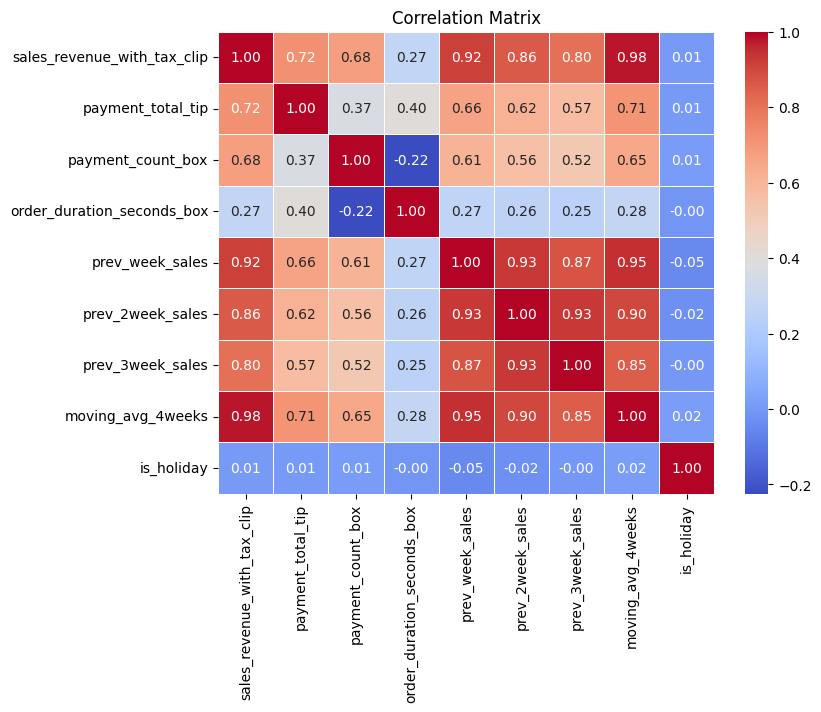

In [39]:
columns = [
    "sales_revenue_with_tax_clip",
    "payment_total_tip",
    "payment_count_box",
    "order_duration_seconds_box",
    "prev_week_sales",
    "prev_2week_sales",
    "prev_3week_sales",
    "moving_avg_4weeks",
    "is_holiday"
]

correlation_matrix = data[columns].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

## Creating sequence data

In [40]:
TARGET_COL = "sales_revenue_with_tax_clip"

num_cols = [
    "payment_total_tip",
    "payment_count_box",
    "order_duration_seconds_box",
    "prev_week_sales",
    "prev_2week_sales",
    "prev_3week_sales",
    "moving_avg_4weeks",
    'is_holiday'
]

cat_cols = [
    "concept",
    "city",
    "venue_xref_id"
]

In [41]:
df_model = df_model.sort_values(["venue_xref_id", "year_week"]).reset_index(drop=True)

In [42]:
df_model.to_csv("model_data.csv", index=False)

In [43]:
def create_sequences(grouped_df, 
                     num_cols, cat_cols, 
                     target_col, 
                     window_size=4):

    X_num_all, X_cat_all, y_all = [], [], []
    
    for v_id in grouped_df["venue_xref_id"].unique():
        sub = grouped_df[grouped_df["venue_xref_id"] == v_id].reset_index(drop=True)
        
        n = len(sub)
        if n <= window_size:
            continue 
        
        for i in range(n - window_size):
            X_num_seq = sub[num_cols].iloc[i : i + window_size].values
            X_cat_seq = sub[cat_cols].iloc[i : i + window_size].values
            y_val = sub[target_col].iloc[i + window_size]
            
            X_num_all.append(X_num_seq)
            X_cat_all.append(X_cat_seq)
            y_all.append(y_val)
    
    X_num_all = np.array(X_num_all)  
    X_cat_all = np.array(X_cat_all) 
    y_all = np.array(y_all)  
    
    return X_num_all, X_cat_all, y_all

X_num, X_cat, y = create_sequences(
    df_model, 
    num_cols=num_cols,
    cat_cols=cat_cols,
    target_col=TARGET_COL,
    window_size=4
)

print("X_num shape:", X_num.shape)
print("X_cat shape:", X_cat.shape)
print("y shape:", y.shape)

X_num shape: (12770, 4, 8)
X_cat shape: (12770, 4, 3)
y shape: (12770,)


## Creating train and test data

In [44]:
train_size = int(len(X_num) * 0.8)

X_num_train = X_num[:train_size]
X_num_test = X_num[train_size:]

X_cat_train = X_cat[:train_size]
X_cat_test = X_cat[train_size:]

y_train = y[:train_size]
y_test = y[train_size:]


In [45]:
window_size = X_num_train.shape[1]
num_numeric_features = X_num_train.shape[2]

X_concept_train = X_cat_train[:, :, 0] 
X_city_train = X_cat_train[:, :, 1]   
X_venue_train = X_cat_train[:, :, 2]    

X_concept_test = X_cat_test[:, :, 0]
X_city_test = X_cat_test[:, :, 1]
X_venue_test = X_cat_test[:, :, 2]


In [46]:
concept_vocab_size = int(X_cat_train[:, :, 0].max()) + 1
city_vocab_size = int(X_cat_train[:, :, 1].max()) + 1
venue_vocab_size = int(X_cat_train[:, :, 2].max()) + 1

emb_dim_concept = 8
emb_dim_city = 8
emb_dim_venue = 16

lstm_units = 32

# Model Building

In [47]:
# 1) Input
concept_input = Input(shape=(window_size,), name="concept_input")   # 예: (None, 4)
city_input    = Input(shape=(window_size,), name="city_input")
venue_input   = Input(shape=(window_size,), name="venue_input")
num_input     = Input(shape=(window_size, num_numeric_features), name="num_input")

# 2) Embedding layers
concept_emb = Embedding(input_dim=concept_vocab_size, 
                        output_dim=8,
                        name="concept_emb")(concept_input)
city_emb = Embedding(input_dim=city_vocab_size, 
                     output_dim=16,
                     name="city_emb")(city_input)
venue_emb = Embedding(input_dim=venue_vocab_size, 
                      output_dim=16,
                      name="venue_emb")(venue_input)


# 3) Feature concatenation
x = Concatenate(axis=2, name="concat_layer")([concept_emb, city_emb, venue_emb, num_input])
x = BatchNormalization()(x)

# 4) LSTM layer with dropout
x = LSTM(32, 
             dropout=0.3,
             recurrent_dropout=0.3,
             kernel_regularizer=l2(0.00017),
             name="lstm_layer")(x)
x = Dropout(0.2)(x)

# 5) Final Dense layer
output = Dense(1, 
               activation="linear", 
               kernel_regularizer=l2(0.00014),
               name="output_layer")(x)
    
model = Model(inputs=[concept_input, city_input, venue_input, num_input], outputs=output)


model.compile(optimizer=Adam(learning_rate=0.0085), loss="mse")
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

2025-02-23 18:13:30.609896: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-02-23 18:13:30.610540: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-02-23 18:13:30.610555: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-02-23 18:13:30.613185: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-23 18:13:30.613963: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 concept_input (InputLayer)  [(None, 4)]                  0         []                            
                                                                                                  
 city_input (InputLayer)     [(None, 4)]                  0         []                            
                                                                                                  
 venue_input (InputLayer)    [(None, 4)]                  0         []                            
                                                                                                  
 concept_emb (Embedding)     (None, 4, 8)                 104       ['concept_input[0][0]']       
                                                                                              

In [48]:
# Train dict
train_dict = {
    "concept_input": X_concept_train,   
    "city_input": X_city_train,
    "venue_input": X_venue_train,
    "num_input": X_num_train          
}

# Test dict
test_dict = {
    "concept_input": X_concept_test,
    "city_input": X_city_test,
    "venue_input": X_venue_test,
    "num_input": X_num_test
}

## Model Training

In [49]:
history = model.fit(
    train_dict,
    y_train,
    validation_data=(
        test_dict,
         y_test
    ),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop,reduce_lr],
    shuffle=False
)

Epoch 1/50


2025-02-23 18:13:31.627883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


320/320 [==============================] - ETA: 0s - loss: 0.0805

2025-02-23 18:13:54.509819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


320/320 [==============================] - 25s 73ms/step - loss: 0.0805 - val_loss: 0.0295 - lr: 0.0085
Epoch 2/50
320/320 [==============================] - 22s 68ms/step - loss: 0.0510 - val_loss: 0.0343 - lr: 0.0085
Epoch 3/50
320/320 [==============================] - 22s 67ms/step - loss: 0.0420 - val_loss: 0.0368 - lr: 0.0085
Epoch 4/50
320/320 [==============================] - 22s 70ms/step - loss: 0.0363 - val_loss: 0.0293 - lr: 0.0085
Epoch 5/50
320/320 [==============================] - 21s 67ms/step - loss: 0.0305 - val_loss: 0.0282 - lr: 0.0085
Epoch 6/50
320/320 [==============================] - 22s 67ms/step - loss: 0.0279 - val_loss: 0.0320 - lr: 0.0085
Epoch 7/50
320/320 [==============================] - 22s 69ms/step - loss: 0.0316 - val_loss: 0.0371 - lr: 0.0085
Epoch 8/50
320/320 [==============================] - 22s 68ms/step - loss: 0.0270 - val_loss: 0.0320 - lr: 0.0085
Epoch 9/50
320/320 [==============================] - 21s 67ms/step - loss: 0.0232 - val_lo

In [50]:
y_pred_bc = model.predict(test_dict).flatten()
y_test_bc = y_test 

11/80 [===>..........................] - ETA: 0s 

2025-02-23 18:18:36.753243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - 1s 6ms/step


# Model Evaluation

## Raw results

In [51]:
mse = mean_squared_error(y_test_bc, y_pred_bc)
rmse = mse**0.5
mae = mean_absolute_error(y_test_bc, y_pred_bc)
r2 = r2_score(y_test_bc, y_pred_bc)

print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test MAE:", mae)
print("Test R^2:", r2)

Test MSE: 0.0223874988824998
Test RMSE: 0.14962452634010173
Test MAE: 0.1092213112222091
Test R^2: 0.6934171180201021


## Transformed results

In [52]:
y_pred_original = scaler.inverse_transform(y_pred_bc.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test_bc.reshape(-1, 1))

In [53]:
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = mse**0.5
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test MAE:", mae)
print("Test R^2:", r2)

Test MSE: 74529890.52662396
Test RMSE: 8633.069588890383
Test MAE: 6301.875795581074
Test R^2: 0.6934171178353821


# Visualisation

## Raw results

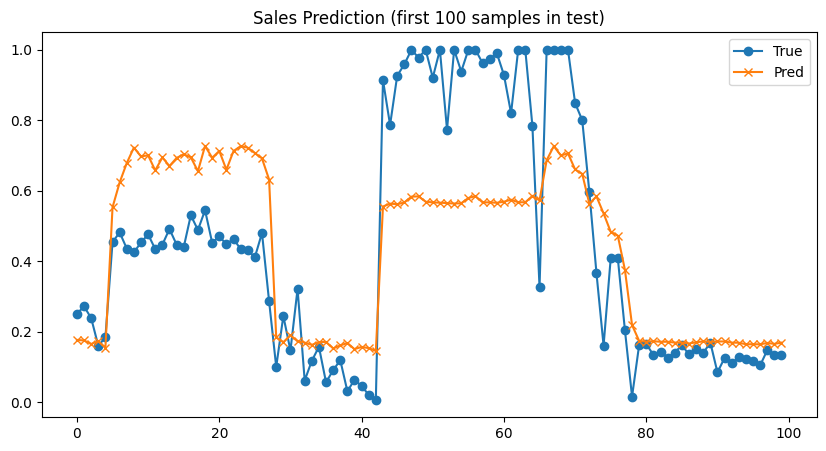

In [54]:
plt.figure(figsize=(10,5))
plt.plot(y_test_bc[:100], label='True', marker='o')
plt.plot(y_pred_bc[:100], label='Pred', marker='x')
plt.title("Sales Prediction (first 100 samples in test)")
plt.legend()
plt.show()

## Transformed results

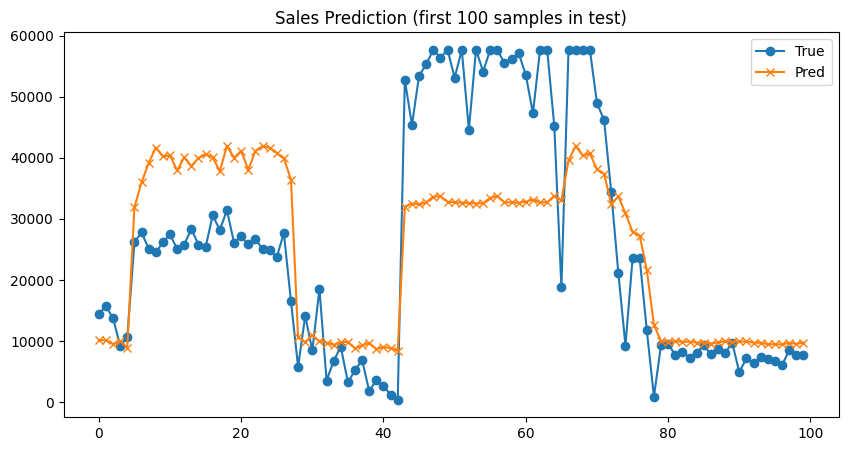

In [55]:
plt.figure(figsize=(10,5))
plt.plot(y_test_original[:100], label='True', marker='o')
plt.plot(y_pred_original[:100], label='Pred', marker='x')
plt.title("Sales Prediction (first 100 samples in test)")
plt.legend()
plt.show()

# Hyperparameter tuning and Cross validation

In [56]:
def build_model(hp):
    concept_input = Input(shape=(window_size,), name="concept_input")
    city_input    = Input(shape=(window_size,), name="city_input")
    venue_input   = Input(shape=(window_size,), name="venue_input")
    num_input     = Input(shape=(window_size, num_numeric_features), name="num_input")
    
    concept_emb = Embedding(input_dim=concept_vocab_size, 
                            output_dim=hp.Choice("emb_dim_concept", values=[8, 16]),
                            name="concept_emb")(concept_input)
    city_emb = Embedding(input_dim=city_vocab_size, 
                         output_dim=hp.Choice("emb_dim_city", values=[8, 16]),
                         name="city_emb")(city_input)
    venue_emb = Embedding(input_dim=venue_vocab_size, 
                          output_dim=hp.Choice("emb_dim_venue", values=[16, 32]),
                          name="venue_emb")(venue_input)

    x = Concatenate(axis=2, name="concat_layer")([concept_emb, city_emb, venue_emb, num_input])
    x = BatchNormalization()(x)

    lstm_units = hp.Choice("lstm_units", values=[32, 64])
    x = LSTM(lstm_units, 
             dropout=hp.Float("lstm_dropout", min_value=0.1, max_value=0.5, step=0.1),
             recurrent_dropout=hp.Float("lstm_recurrent_dropout", min_value=0.1, max_value=0.5, step=0.1),
             kernel_regularizer=l2(hp.Float("l2_reg", min_value=1e-4, max_value=1e-2, sampling="log")),
             name="lstm_layer")(x)
    
    x = Dropout(hp.Float("dense_dropout", min_value=0.1, max_value=0.5, step=0.1))(x)
    output = Dense(1, 
                   activation="linear", 
                   kernel_regularizer=l2(hp.Float("dense_l2_reg", min_value=1e-4, max_value=1e-2, sampling="log")),
                   name="output_layer")(x)
    
    model = Model(inputs=[concept_input, city_input, venue_input, num_input], outputs=output)
    
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(optimizer=Adam(learning_rate), loss="mse")
    return model

## Hyperparameter tuning

In [57]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=70,  
    factor=3,
    directory='my_dir',
    project_name='tuning_project'
)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

X_train_dict = {
    "concept_input": X_concept_train,
    "city_input": X_city_train,
    "venue_input": X_venue_train,
    "num_input": X_num_train
}

tuner.search(X_train_dict, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop])
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hp.values)

Trial 90 Complete [00h 08m 39s]
val_loss: 0.009257919155061245

Best val_loss So Far: 0.009155555628240108
Total elapsed time: 03h 59m 08s
Best Hyperparameters: {'emb_dim_concept': 8, 'emb_dim_city': 8, 'emb_dim_venue': 16, 'lstm_units': 64, 'lstm_dropout': 0.4, 'lstm_recurrent_dropout': 0.1, 'l2_reg': 0.000432025255103857, 'dense_dropout': 0.4, 'dense_l2_reg': 0.00018053466037698624, 'learning_rate': 0.0016335484621002611, 'tuner/epochs': 24, 'tuner/initial_epoch': 8, 'tuner/bracket': 3, 'tuner/round': 2, 'tuner/trial_id': '0045'}


## KFold Cross validation

In [58]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mse_scores = []
cv_mse_original = []
cv_r2_scores = []
cv_y_pred_original = []  
cv_y_val_original = []  

for train_index, val_index in kf.split(X_concept_train):
    X_train_fold = {
        "concept_input": X_concept_train[train_index],
        "city_input": X_city_train[train_index],
        "venue_input": X_venue_train[train_index],
        "num_input": X_num_train[train_index]
    }
    X_val_fold = {
        "concept_input": X_concept_train[val_index],
        "city_input": X_city_train[val_index],
        "venue_input": X_venue_train[val_index],
        "num_input": X_num_train[val_index]
    }
    y_train_fold = y_train[train_index]
    y_val_fold = y_train[val_index]
    
    model_cv = build_model(best_hp)
    epochs_val = best_hp.values.get('epochs', 50)
    batch_size_val = best_hp.values.get('batch_size', 32)
    model_cv.fit(X_train_fold, y_train_fold, epochs=epochs_val, batch_size=batch_size_val, verbose=0)

    # Evaluating Model
    mse_score = model_cv.evaluate(X_val_fold, y_val_fold, verbose=0)
    cv_mse_scores.append(mse_score)
    
    y_val_pred = model_cv.predict(X_val_fold)
    
    y_val_pred_original = scaler.inverse_transform(y_val_pred.reshape(-1, 1))
    y_val_fold_original = scaler.inverse_transform(y_val_fold.reshape(-1, 1))
    
    cv_y_pred_original.append(y_val_pred_original)
    cv_y_val_original.append(y_val_fold_original)

    mse_original = mean_squared_error(y_val_fold_original, y_val_pred_original)
    cv_mse_original.append(mse_original)
    r2 = r2_score(y_val_fold_original, y_val_pred_original)
    cv_r2_scores.append(r2)

print("Cross Validation MSE Scores:", cv_mse_scores)
print("Average CV MSE:", np.mean(cv_mse_scores))
print("Cross Validation R^2 Scores:", cv_r2_scores)
print("Average CV R^2:", np.mean(cv_r2_scores))

2025-02-23 22:17:46.682849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-23 22:34:00.658259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-23 22:34:02.336069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 1s 9ms/step


2025-02-23 22:34:03.969590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-23 22:50:40.397877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-23 22:50:42.151609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 2s 19ms/step


2025-02-23 22:50:44.369038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-23 23:07:53.202570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-23 23:07:54.845637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 1s 9ms/step


2025-02-23 23:07:56.500258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-23 23:22:48.545212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-23 23:22:50.114981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 1s 8ms/step


2025-02-23 23:22:51.500175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-23 23:38:23.190084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-23 23:38:24.779686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 1s 7ms/step
Cross Validation MSE Scores: [0.007433849852532148, 0.007512206677347422, 0.007404771633446217, 0.0070454939268529415, 0.007023873273283243]
Average CV MSE: 0.007284039072692395
Cross Validation R^2 Scores: [0.9128994649534694, 0.9149425668710709, 0.9148233315720125, 0.9212212798547637, 0.9234238141556632]
Average CV R^2: 0.9174620914813959


In [59]:
best_model = tuner.get_best_models(num_models=1)[0]

# Final Model Evaluation

In [60]:
predictions = best_model.predict(test_dict).flatten()

2025-02-23 23:38:27.268851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - 1s 8ms/step


In [61]:
mse = mean_squared_error(y_test_bc, predictions)
rmse = mse**0.5
mae = mean_absolute_error(y_test_bc, predictions)
r2 = r2_score(y_test_bc, predictions)

print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test MAE:", mae)
print("Test R^2:", r2)

Test MSE: 0.007908625458844987
Test RMSE: 0.08893045293286764
Test MAE: 0.06039997691574064
Test R^2: 0.8916962900412415


In [62]:
y_pred_original = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test_bc.reshape(-1, 1))

In [63]:
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = mse**0.5
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test MAE:", mae)
print("Test R^2:", r2)

Test MSE: 26328487.713145994
Test RMSE: 5131.129282443193
Test MAE: 3484.9714671073566
Test R^2: 0.8916962900509219


# Visualisation

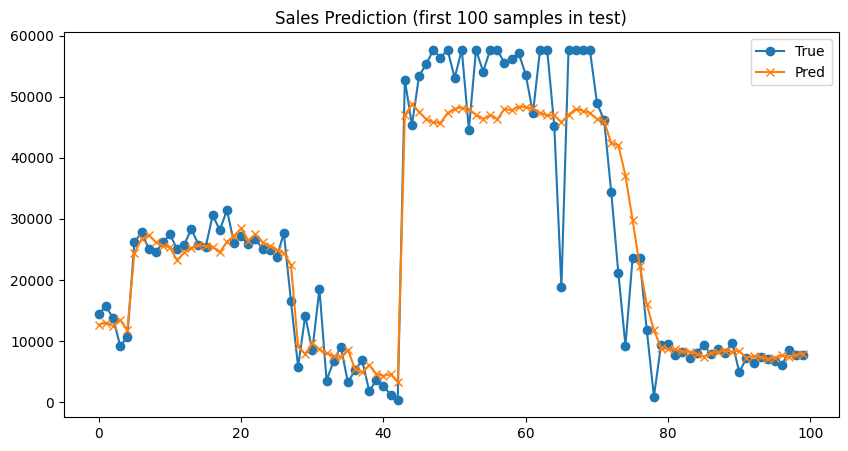

In [64]:
plt.figure(figsize=(10,5))
plt.plot(y_test_original[:100], label='True', marker='o')
plt.plot(y_pred_original[:100], label='Pred', marker='x')
plt.title("Sales Prediction (first 100 samples in test)")
plt.legend()
plt.show()

# Final Model

In [65]:
train_dict_full = {
    "concept_input": X_cat[:, :, 0],
    "city_input": X_cat[:, :, 1],
    "venue_input": X_cat[:, :, 2],
    "num_input": X_num
}

In [67]:
final_epochs = best_hp.values.get('tuner/epochs', 50)
final_batch_size = best_hp.values.get('batch_size', 32)

history = best_model.fit(
    train_dict_full,
    y,
    epochs=final_epochs,
    batch_size=final_batch_size,
    verbose=1
)

Epoch 1/24


2025-02-24 04:13:02.166427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


400/400 [==============================] - 32s 74ms/step - loss: 0.0107
Epoch 2/24
400/400 [==============================] - 28s 70ms/step - loss: 0.0106
Epoch 3/24
400/400 [==============================] - 28s 70ms/step - loss: 0.0098
Epoch 4/24
400/400 [==============================] - 28s 69ms/step - loss: 0.0100
Epoch 5/24
400/400 [==============================] - 30s 74ms/step - loss: 0.0104
Epoch 6/24
400/400 [==============================] - 28s 69ms/step - loss: 0.0094
Epoch 7/24
400/400 [==============================] - 28s 69ms/step - loss: 0.0097
Epoch 8/24
400/400 [==============================] - 28s 69ms/step - loss: 0.0096
Epoch 9/24
400/400 [==============================] - 28s 69ms/step - loss: 0.0090
Epoch 10/24
400/400 [==============================] - 28s 69ms/step - loss: 0.0094
Epoch 11/24
400/400 [==============================] - 28s 70ms/step - loss: 0.0095
Epoch 12/24
400/400 [==============================] - 28s 69ms/step - loss: 0.0092
Epoch 13/24


In [68]:
best_model.save("final_model.h5")

/Users/jeongwoohong/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
